In this project, I made a simple Linear Regression model to predict number of points gained based on Expected Goals. <br>
Data is scraped from Fbref.com website. <br>
Data containes statistics for teams from the last 4 seasons.

In [267]:
# Importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns

In [268]:
# Setting up table scraper
def scrape_fbref(url, table_number):
    #Defining variables - url to the website + the table of choice (starting from 0 for the first table on the top)
    url = url
    table_number = table_number
    global data
    #Changing Fbref's HTML so all tables are redable by bs4
    html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
    dataframe = pd.read_html(html_content)
    #Loading DF
    data = dataframe[table_number]

In [269]:
# Defining columns to use and links to tables from particular seasons
cols = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'xG', 'xGA', 'xGD']
season_links = ['https://fbref.com/en/comps/Big5/2020-2021/2020-2021-Big-5-European-Leagues-Stats',
          'https://fbref.com/en/comps/Big5/2019-2020/2019-2020-Big-5-European-Leagues-Stats',
          'https://fbref.com/en/comps/Big5/2018-2019/2018-2019-Big-5-European-Leagues-Stats',
          'https://fbref.com/en/comps/Big5/2017-2018/2017-2018-Big-5-European-Leagues-Stats']

In [270]:
# Merging tables from 4 seasons into one dataframe
appended_data = []
for i in range(4):
    scrape_fbref(season_links[i], 0)
    data = data[cols]
    appended_data.append(data)

In [271]:
df = pd.concat(appended_data)
df.loc[df['Squad'] == 'Chelsea']

,Squad,MP,W,D,L,GF,GA,GD,Pts,xG,xGA,xGD
21,Chelsea,38,19,10,9,58,36,22,67,64.0,32.8,31.2
22,Chelsea,38,20,6,12,69,54,15,66,66.6,37.9,28.6
11,Chelsea,38,21,9,8,63,39,24,72,59.0,35.3,23.7
19,Chelsea,38,21,7,10,62,38,24,70,57.9,35.3,22.7


As most of the teams have been added 4 times, I have decided to merge duplicates and divide the score by 4 in order to get realistic data

In [272]:
cols_to_sum = ['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'xG', 'xGA', 'xGD']
df[cols_to_sum] = df.groupby('Squad')[cols_to_sum].transform('sum')
df = df.drop_duplicates(subset='Squad')
df[cols_to_sum] = df[cols_to_sum].div(4)
df.loc[df['Squad'] == 'Chelsea']

,Squad,MP,W,D,L,GF,GA,GD,Pts,xG,xGA,xGD
21,Chelsea,38.0,20.25,8.0,9.75,63.0,41.75,21.25,68.75,61.875,35.325,26.55


In [273]:
df.loc[df['Pts'] < 25].sort_values('Pts').head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,xG,xGA,xGD
95,Nürnberg,8.5,0.75,2.50,5.25,6.50,17.00,-10.50,4.75,8.250,13.925,-5.650
97,Málaga,9.5,1.25,1.25,7.00,6.00,15.25,-9.25,5.00,8.275,13.425,-5.150
94,Paderborn 07,8.5,1.00,2.00,5.50,9.25,18.50,-9.25,5.00,9.600,16.875,-7.250
95,Norwich City,9.5,1.25,1.50,6.75,6.50,18.75,-12.25,5.25,9.500,15.475,-5.975
95,Las Palmas,9.5,1.25,1.75,6.50,6.00,18.50,-12.50,5.50,9.350,16.600,-7.275


Since dividing all results leads to lowering scores for teams that haven't played in the top 5 leagues for whole 4 seasons, I will drop all teams with less than 25 points

In [274]:
df = df.loc[df['Pts'] > 24]

<AxesSubplot:xlabel='xG', ylabel='Pts'>

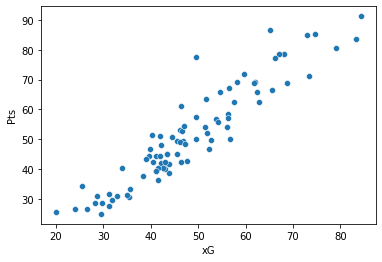

In [275]:
sns.scatterplot(x='xG', y='Pts', data=df)

From the scatterplot it is clear, that there is a big corelation between these variables. <br>
Now, let's built a Linear Regression model.

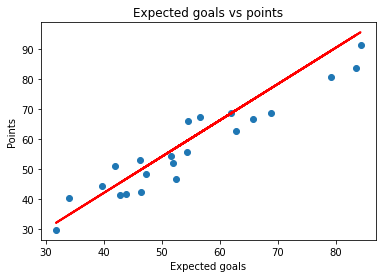

In [276]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df['xG'].values.reshape(-1, 1)
y = df['Pts'].values.reshape(-1, 1)
reg = LinearRegression()

# Model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Visualizing the model
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title("Expected goals vs points")
plt.xlabel('Expected goals')
plt.ylabel('Points')
plt.show()

In [277]:
print(f'For every expected goal, team gaines by average {reg.coef_.round(2)} points.')

For every expected goal, team gaines by average [[1.21]] points.


In [278]:
r_squared = reg.score(X_test, y_test)
print(f'R squared = {r_squared}')

R squared = 0.8470299309346229


Example of usage: <br>
Predicting points at the end of the season for teams, that gathered 50, 70, 25 and 100 expected goals during a season.

In [279]:
X_new = np.array([50, 70, 25, 100]).reshape(-1, 1)
y_new = reg.predict(X_new)
y_new

array([[ 54.14642404],
       [ 78.3216324 ],
       [ 23.92741358],
       [114.58444495]])

Disadvantages of this model: <br>
Model does not count Expected Goals Against, so prediction for teams that score and concede a lot of goals will not be accurate at all; <br>
Model is based on mean data from 4 seasons, which could be misleading for predicting outcomes during one particular season.